## Visualize readout map

Code reference: [github.com/sinzlab/sensorium/notebooks/model_tutorial/2_model_evaluation_and_inspection.ipynb](https://github.com/sinzlab/sensorium/blob/e5017df2ff89c60a4d0a7687c4bde67774de346b/notebooks/model_tutorial/2_model_evaluation_and_inspection.ipynb)

In [12]:
import os
import torch
import numpy as np
from PIL import ImageColor
import matplotlib.pyplot as plt

from v1t import data
from v1t.models.model import Model
from v1t.utils import utils, tensorboard
from v1t.utils.scheduler import Scheduler


utils.set_random_seed(1234)

BACKGROUND_COLOR = "#ffffff"
tensorboard.set_font()

In [13]:
class Args:
    def __init__(self):
        self.dataset = "../data/sensorium"
        self.output_dir = "../runs/sensorium+/116_vit_gaussian2d_gradCheckpointing"
        self.device = torch.device("cpu")
        self.batch_size = 1


args = Args()
utils.load_args(args)

In [14]:
_, val_ds, _ = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

model = Model(args, ds=val_ds)

scheduler = Scheduler(args, model=model, save_optimizer=False)
_ = scheduler.restore(force=True)


Loaded checkpoint from epoch 120 (correlation: 0.4612).



Helpers for Readout-Position Color Plot

In [15]:
# smooth color interpolation
def lerp(x, a, b):
    return a + x * (b - a)


# smooth color interpolation
def serp(x, a, b):
    return a + (3 * x**2 - 2 * x**3) * (b - a)


def get_color(x, y, a, b, c, d, interpolation="linear"):
    if interpolation == "linear":
        img = np.array(
            [lerp(y, lerp(x, a[i], b[i]), lerp(x, c[i], d[i])) for i in range(3)]
        )
    else:
        img = np.array(
            [serp(y, serp(x, a[i], b[i]), serp(x, c[i], d[i])) for i in range(3)]
        )
    return img


def get_base_colormap(c1, c2, c3, c4, n=200, interpolation="linear"):
    w = h = n
    verts = [c1, c2, c3, c4]
    img = np.empty((h, w, 3), np.uint8)
    for y in range(h):
        for x in range(w):
            img[y, x] = get_color(x / w, y / h, *verts, interpolation=interpolation)
    return img


class ColorMap2D:
    def __init__(
        self,
        cmap_array,
        transpose=False,
        reverse_x=False,
        reverse_y=False,
        xclip=None,
        yclip=None,
    ):
        """
        Maps two 2D array to an RGB color space based on a given reference image.
        Args:
            filename (str): reference image to read the x-y colors from
            rotate (bool): if True, transpose the reference image (swap x and y axes)
            reverse_x (bool): if True, reverse the x scale on the reference
            reverse_y (bool): if True, reverse the y scale on the reference
            xclip (tuple): clip the image to this portion on the x scale; (0,1) is the whole image
            yclip  (tuple): clip the image to this portion on the y scale; (0,1) is the whole image
        """
        self._img = cmap_array
        if transpose:
            self._img = self._img.transpose()
        if reverse_x:
            self._img = self._img[::-1, :, :]
        if reverse_y:
            self._img = self._img[:, ::-1, :]
        if xclip is not None:
            imin, imax = map(lambda x: int(self._img.shape[0] * x), xclip)
            self._img = self._img[imin:imax, :, :]
        if yclip is not None:
            imin, imax = map(lambda x: int(self._img.shape[1] * x), yclip)
            self._img = self._img[:, imin:imax, :]
        if issubclass(self._img.dtype.type, np.integer):
            self._img = self._img / 255.0

        self._width = len(self._img)
        self._height = len(self._img[0])

        self._range_x = (0, 1)
        self._range_y = (0, 1)

    @staticmethod
    def _scale_to_range(u: np.ndarray, u_min: float, u_max: float) -> np.ndarray:
        return (u - u_min) / (u_max - u_min)

    def _map_to_x(self, val: np.ndarray) -> np.ndarray:
        xmin, xmax = self._range_x
        val = self._scale_to_range(val, xmin, xmax)
        rescaled = val * (self._width - 1)
        return rescaled.astype(int)

    def _map_to_y(self, val: np.ndarray) -> np.ndarray:
        ymin, ymax = self._range_y
        val = self._scale_to_range(val, ymin, ymax)
        rescaled = val * (self._height - 1)
        return rescaled.astype(int)

    def __call__(self, val_x, val_y):
        """
        Take val_x and val_y, and associate the RGB values
        from the reference picture to each item. val_x and val_y
        must have the same shape.
        """
        if val_x.shape != val_y.shape:
            raise ValueError(
                f"x and y array must have the same shape, but have {val_x.shape} and {val_y.shape}."
            )
        self._range_x = (np.amin(val_x), np.amax(val_x))
        self._range_y = (np.amin(val_y), np.amax(val_y))
        x_indices = self._map_to_x(val_x)
        y_indices = self._map_to_y(val_y)
        i_xy = np.stack((x_indices, y_indices), axis=-1)
        rgb = np.zeros((*val_x.shape, 3))
        for indices in np.ndindex(val_x.shape):
            img_indices = tuple(i_xy[indices])
            rgb[indices] = self._img[img_indices]
        return rgb

    def generate_cbar(self, nx=100, ny=100):
        "generate an image that can be used as a 2D colorbar"
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        return self.__call__(*np.meshgrid(x, y))

In [16]:
def ceil(value: float, precision: int = 0):
    return np.true_divide(np.ceil(value * 10**precision), 10**precision)


def floor(value: float, precision: int = 0):
    return np.true_divide(np.floor(value * 10**precision), 10**precision)

In [17]:
def plot_readout_coordinate_map(
    mouse_id: str, coordinates: np.ndarray, positions: np.ndarray, filename: str = ""
):
    tick_fontsize, label_fontsize = 10, 12
    rgb_colors = [
        ImageColor.getcolor(i, "RGB")
        for i in ["#ef476f", "#ffd166", "#118ab2", "#073b4c"]
    ]
    img = get_base_colormap(*rgb_colors, interpolation="smooth")

    # instantiate 2D Colormap Class with the base colormap
    Cmap_2D = ColorMap2D(img)

    # get RGB tuples for all readout positions based on the colormap
    xmin, xmax = floor(np.min(positions[:, 0]), 1), ceil(np.max(positions[:, 0]), 1)
    ymin, ymax = floor(np.min(positions[:, 1]), 1), ceil(np.max(positions[:, 1]), 1)
    rgb = Cmap_2D(*positions.T)

    figure, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 6),
        dpi=120,
        facecolor=BACKGROUND_COLOR,
    )

    # Show Anatomical Positions
    ax.scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        c=rgb.squeeze(),
        alpha=0.75,
        s=40,
    )
    ax.set_title(
        f"Mouse {data.convert_id(mouse_id)} anatomical coordinates color-coded by readout position"
    )
    tensorboard.set_xticks(
        axis=ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 0]), np.max(coordinates[:, 0]), 5
        ).astype(int),
        label="x coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 1]), np.max(coordinates[:, 1]), 5
        ).astype(int),
        label="y coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )

    plt.subplots_adjust(left=0.1, right=0.65)

    x_range = np.linspace(xmin, xmax, 3)
    y_range = np.linspace(ymin, ymax, 3)
    # show 2D Colormap
    bar_ax = figure.add_axes([0.68, 0.57, 0.3, 0.3])
    bar_ax.imshow(
        Cmap_2D.generate_cbar(),
        extent=(xmin, xmax, ymin, ymax),
        aspect="auto",
        origin="lower",
    )
    bar_ax.set_title("Colormap")
    tensorboard.set_xticks(
        axis=bar_ax,
        ticks_loc=x_range,
        ticks=x_range.round(2),
        label="horizontal",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=bar_ax,
        ticks_loc=y_range,
        ticks=y_range.round(2)[::-1],
        label="vertical",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    bar_ax.yaxis.tick_right()
    bar_ax.yaxis.set_label_position("right")
    bar_ax.invert_yaxis()
    tensorboard.set_ticks_params(axis=bar_ax)

    # plot readout positions
    pos_ax = figure.add_axes([0.68, 0.13, 0.3, 0.3])
    pos_ax.scatter(*positions.T, alpha=0.25, c="k", edgecolor="w")
    pos_ax.set_title("Gaussian readout positions")
    pos_ax.yaxis.tick_right()
    pos_ax.yaxis.set_label_position("right")
    tensorboard.set_xticks(
        axis=pos_ax,
        ticks_loc=x_range,
        ticks=x_range.round(2),
        label="horizontal",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=pos_ax,
        ticks_loc=y_range,
        ticks=y_range.round(2),
        label="vertical",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_ticks_params(axis=pos_ax)

    plt.show()

    if filename:
        tensorboard.save_figure(figure=figure, filename=filename)

Plot Mouse A neuron coordinates

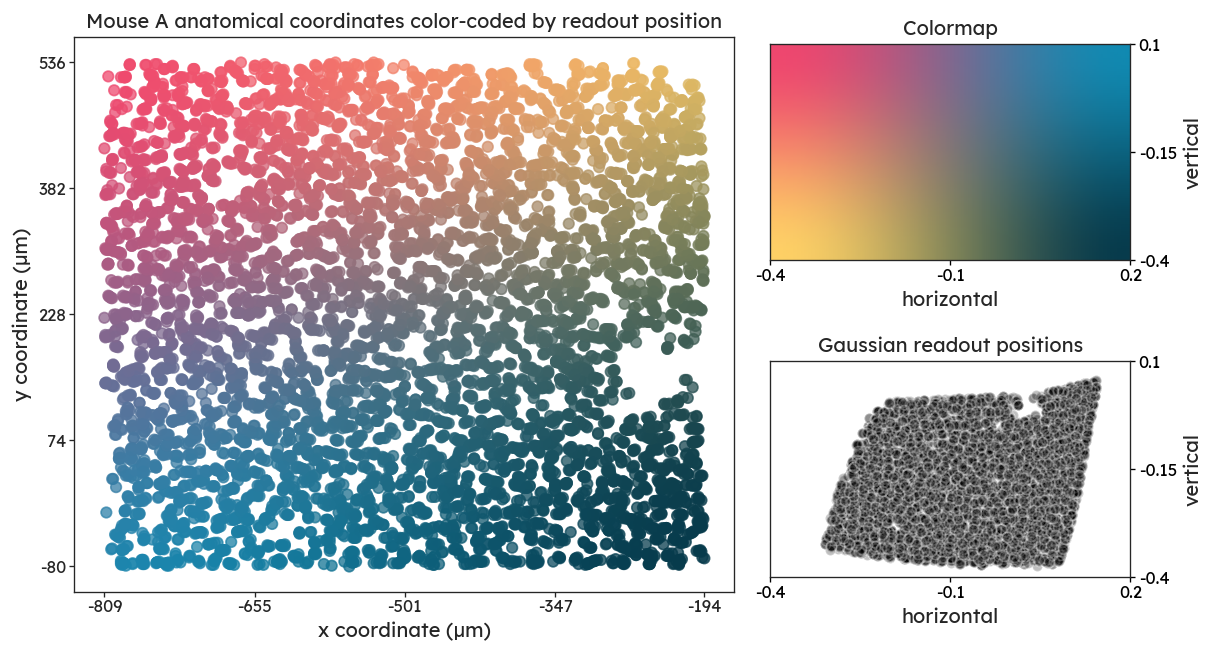

In [18]:
mouse_id = "2"

plot_readout_coordinate_map(
    mouse_id=mouse_id,
    coordinates=val_ds[mouse_id].dataset.coordinates,
    positions=model.readouts[mouse_id].mu.squeeze().detach().numpy(),
    filename=os.path.join(
        args.output_dir,
        "plots",
        f"readout_coordinates_mouse{data.convert_id(mouse_id)}.svg",
    ),
)

Plot Mouse B neuron coordinates

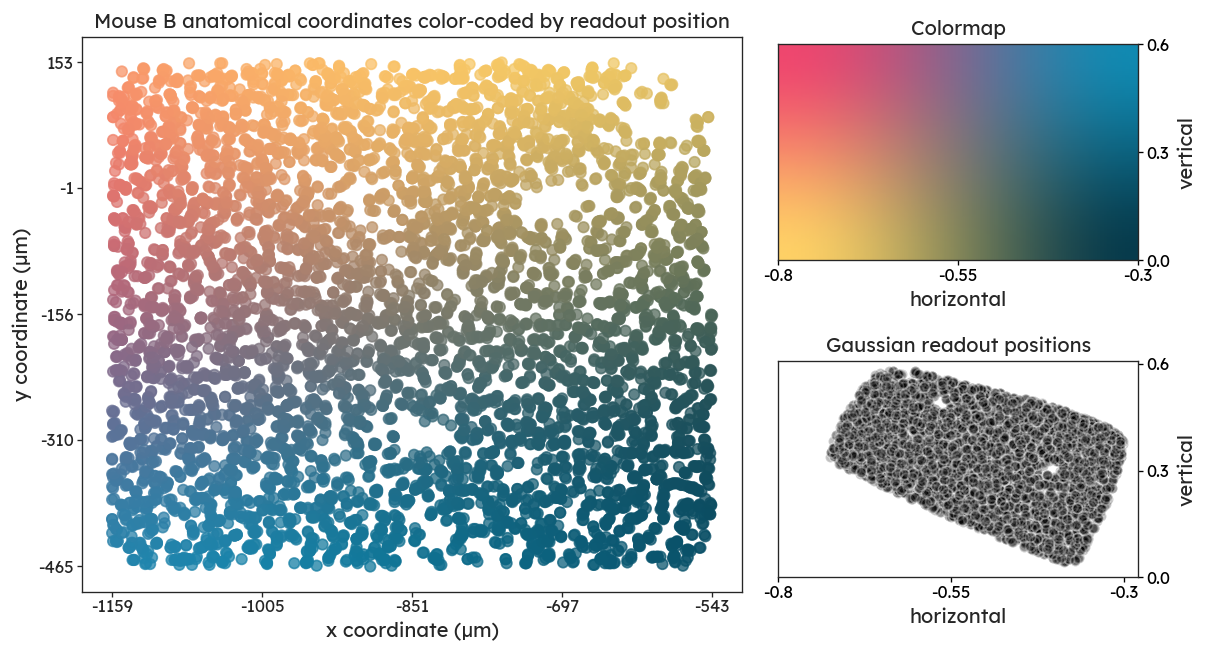

In [19]:
mouse_id = "3"

plot_readout_coordinate_map(
    mouse_id=mouse_id,
    coordinates=val_ds[mouse_id].dataset.coordinates,
    positions=model.readouts[str(mouse_id)].mu.squeeze().detach().numpy(),
    filename=os.path.join(
        args.output_dir,
        "plots",
        f"readout_coordinates_mouse{data.convert_id(mouse_id)}.svg",
    ),
)

Plot Mouse C neuron coordinates

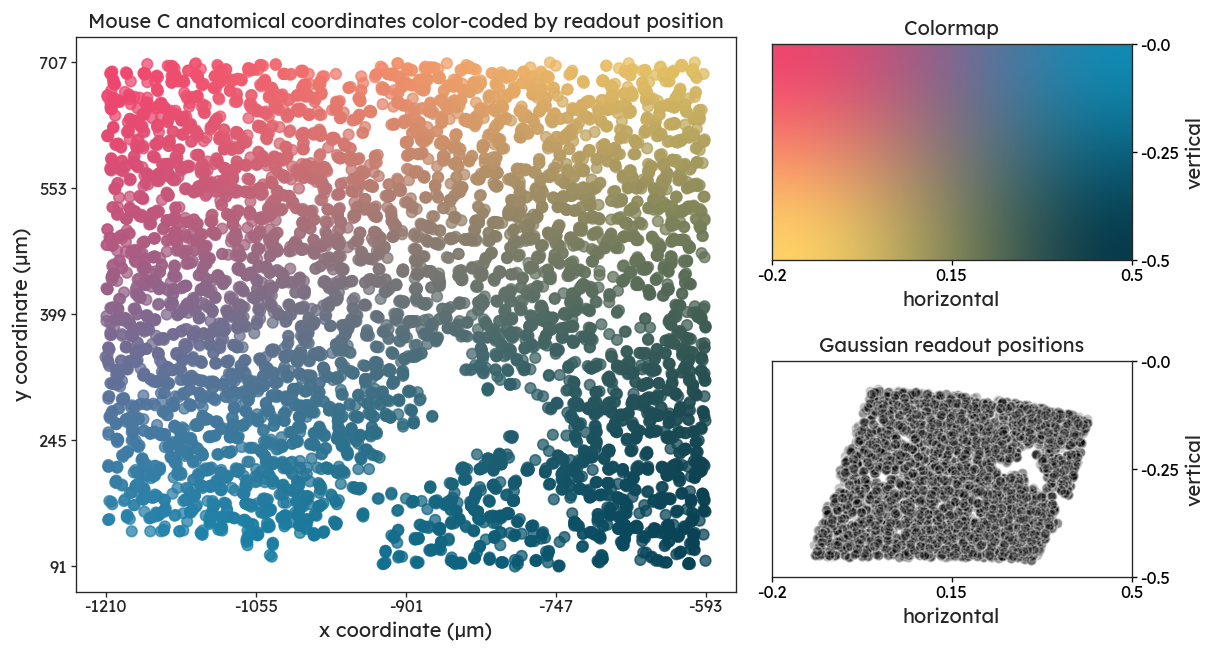

In [20]:
mouse_id = "4"

plot_readout_coordinate_map(
    mouse_id=mouse_id,
    coordinates=val_ds[mouse_id].dataset.coordinates,
    positions=model.readouts[str(mouse_id)].mu.squeeze().detach().numpy(),
    filename=os.path.join(
        args.output_dir,
        "plots",
        f"readout_coordinates_mouse{data.convert_id(mouse_id)}.svg",
    ),
)

Plot Mouse D neuron coordinates

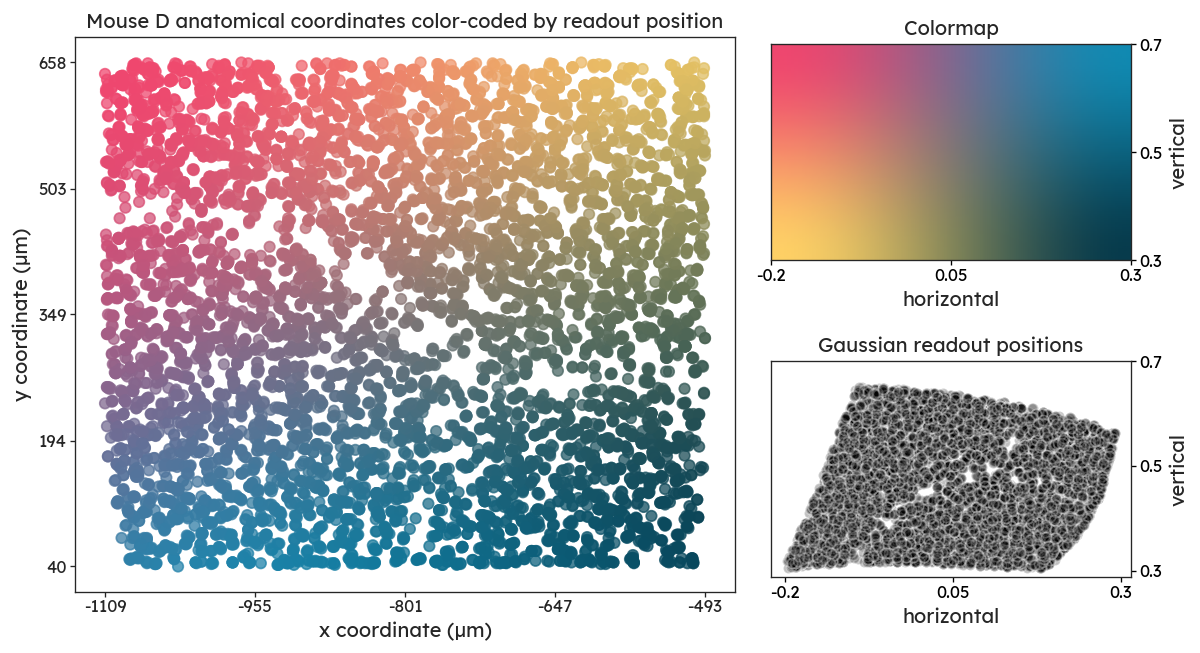

In [21]:
mouse_id = "5"

plot_readout_coordinate_map(
    mouse_id=mouse_id,
    coordinates=val_ds[mouse_id].dataset.coordinates,
    positions=model.readouts[str(mouse_id)].mu.squeeze().detach().numpy(),
    filename=os.path.join(
        args.output_dir,
        "plots",
        f"readout_coordinates_mouse{data.convert_id(mouse_id)}.svg",
    ),
)

Plot Mouse E neuron coordinates

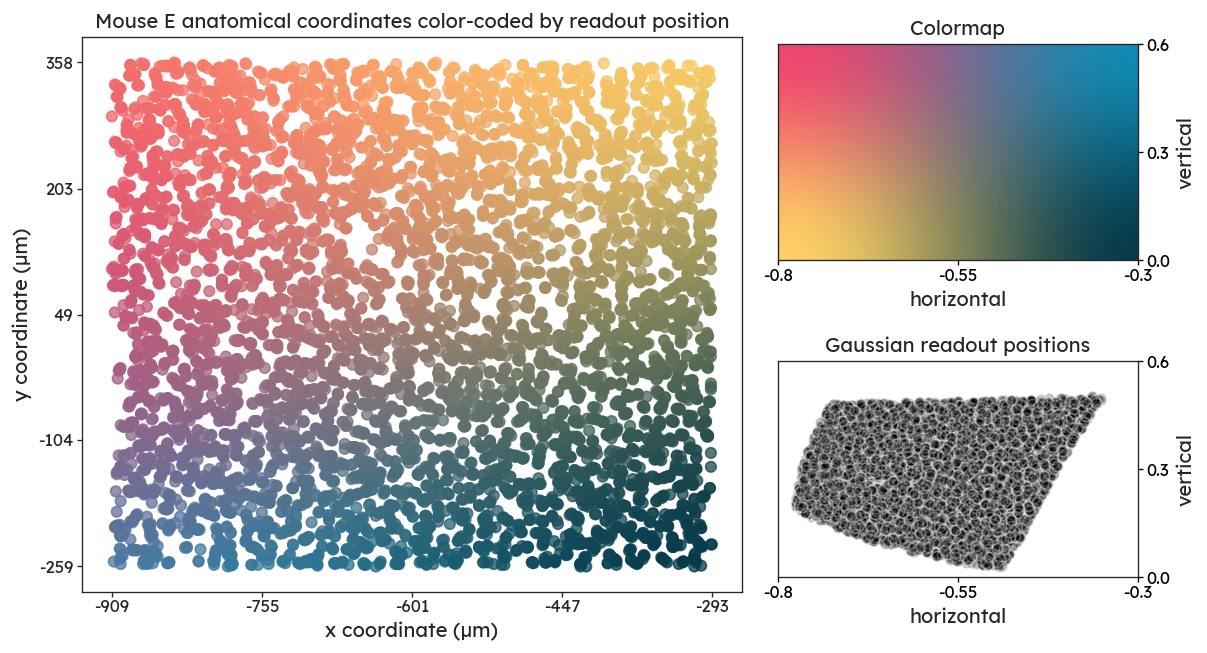

In [22]:
mouse_id = "6"

plot_readout_coordinate_map(
    mouse_id=mouse_id,
    coordinates=val_ds[mouse_id].dataset.coordinates,
    positions=model.readouts[str(mouse_id)].mu.squeeze().detach().numpy(),
    filename=os.path.join(
        args.output_dir,
        "plots",
        f"readout_coordinates_mouse{data.convert_id(mouse_id)}.svg",
    ),
)